In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchmetrics
import zarr
from load_data_for_analysis import *

save_fig = "/data/mikulik/PolarbearPlus/notebooks/figures/"
data_dir = "/data/mikulik/PolarbearPlus/notebooks/data/"

In [3]:
def normalize_counts(x, normlib=True, logscale=True):
    if normlib:
        ## compare with normalized true profile
        lib = x.sum(axis=1, keepdims=True)
        x = x / lib
    if logscale:
        x = np.log1p(x)
    return x


def corr_obs_reocnstr(x, y, per_gene=True, data_type="RNA", plot=False):
    num_genes, num_cells = x.shape[1], y.shape[0]

    x, y = torch.from_numpy(x), torch.from_numpy(y)

    if per_gene:
        pearson = torchmetrics.PearsonCorrCoef(num_outputs=num_genes)
        corr = pearson(x, y)
        if plot:
            sns.histplot(corr)
            if data_type == "RNA":
                plt.title("Correlation across cells for each gene")
            else:
                plt.title("Correlation across cells for each peak")
            plt.xlabel(f"mean: {corr.mean():.3f}")
            plt.show()

    if per_gene == False:
        pearson = torchmetrics.PearsonCorrCoef(num_outputs=num_cells)
        corr = pearson(x.T, y.T)
        if plot:
            sns.histplot(corr)
            if data_type == "RNA":
                plt.title("Correlation across genes for each cell")
            else:
                plt.title("Correlation across peaks for each cell")
            plt.xlabel(f"mean: {corr.mean():.3f}")
            plt.show()
    return corr

In [4]:
snareseq_barcodes, snareseq_peaks, gene_names = load_snare_data(os.path.join(data_dir, "snareseq"))
true_split = get_test_split_index(os.path.join(data_dir, "split"))
test_cell_names = get_celltype_annotations(
    os.path.join(data_dir, "diffexp"), snareseq_barcodes=snareseq_barcodes, true_split=true_split
)

diff_genes = load_diff_genes(os.path.join(data_dir, "diffexp"))
diff_genes_ind = get_diff_gene_ind(gene_names, diff_genes)

rna_counts, obs_rna = get_rna_counts(os.path.join(data_dir, "snareseq/"), true_split)
atac_counts, obs_atac = get_atac_counts(os.path.join(data_dir, "snareseq/"), true_split)

diff_peaks_ind = get_diff_peaks_ind(os.path.join(data_dir, "diffexp"), snareseq_peaks)

# Compute Correlations

### Load saved predictions

In [5]:
data_dir = "/data/mikulik/mnt_polarbear_exp/"

In [6]:
def index_1d_to_2d(index, width):
    row = index // width
    col = index % width
    return row, col


def get_index_array(x):
    ind_arr = np.arange(x.flatten().shape[0]).reshape(x.shape)
    return ind_arr

In [7]:
def scale_quantiles(counts, q025, q975):
    condition = counts > 0
    obs_scale = (counts[condition] - q025[condition]) / (q975[condition] - q025[condition])
    return obs_scale

In [8]:
def read_vae(data_dir, vae="rnavae"):
    x = zarr.open(os.path.join(data_dir, vae, "settings_polarbear/prediction/stats.zarr"), mode="r")
    q025 = np.asarray(x["reconstruction_stats"]["q0.025"])
    q975 = np.asarray(x["reconstruction_stats"]["q0.975"])
    # obs_norm =obs_rna/obs_rna.sum(axis=1, keepdims=True)
    # print(q025.min(), q025.max())
    return q025, q975


def read_translator(data_dir, translator, file):
    x = zarr.open(os.path.join(data_dir, translator, file, "prediction/stats.zarr"))
    q025, q95, q975 = np.asarray(x["q0.025"]), np.asarray(x["q0.95"]), np.asarray(x["q0.975"])
    return q025, q975

In [9]:
def plot_ci(obs_scale, title=""):
    sns.histplot(obs_scale)
    plt.axvline(1, color="black")
    plt.axvline(0, color="black")
    plt.ylabel("Counts", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(f"{title}", fontsize=30)
    plt.show()

# Confidence Intervals

In [10]:
plot_df = {}

#### RNA

In [11]:
# plt.title(title, fontsize=30)
# sns.lineplot(x=x, y=x, c="black")
# plt.ylabel(f"{y_label}, mean:{y.mean():.3f}" , fontsize=20)
# plt.xlabel(f"{x_label}, mean: {x.mean():.3f}", fontsize=20)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.tick_params(axis='both', which='major', labelsi

/tmp/ipykernel_39847/3893850416.py:3: RuntimeWarning: divide by zero encountered in divide
  obs_scale = (counts[condition] - q025[condition]) / (q975[condition] - q025[condition])


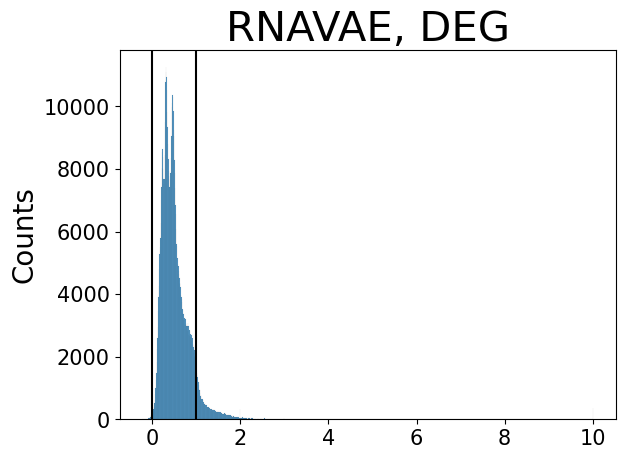

In [12]:
q025, q975 = read_vae(data_dir="/data/mikulik/mnt_polarbear_exp/", vae="rnavae")
obs_scale = scale_quantiles(obs_rna[:, diff_genes_ind], q025[:, diff_genes_ind], q975[:, diff_genes_ind])
plot_ci(np.clip(obs_scale.reshape(-1), -1, 10), title="RNAVAE, DEG")
plot_df["RNAVAE"] = np.clip(obs_scale.reshape(-1), -1, 10).tolist()
# print(f"Percentage of predictions that are bigger than 1, {file}:{(obs_scale > 1).sum() / obs_scale.shape[0]}")
# print(f"Percentage of predictions that are smaller than 0, {file}: {(obs_scale < 0).sum() / obs_scale.shape[0]}")

#### MLP and INN

In [13]:
# normalize counts
obs_norm = obs_rna / obs_rna.sum(axis=1, keepdims=True)
clips = {"mlptranslator": [100, 5000], "inntranslator": [50, 50, 50]}

outputs = "/data/mikulik/mnt_polarbear_exp/"
subdirs = ["mlptranslator", "inntranslator"]
for subdir in subdirs:
    for file, clip in zip(
        [i for i in os.listdir(os.path.join(outputs, subdir)) if "atac2rna" in i], clips[subdir], strict=False
    ):
        q025, q975 = read_translator(outputs, subdir, file)
        obs_scale = scale_quantiles(obs_norm[:, diff_genes_ind], q025[:, diff_genes_ind], q975[:, diff_genes_ind])
        # plot_ci(obs_scale[obs_scale < clip], title=f"{subdir}, {file}, DEG")
        plot_df[file] = obs_scale[obs_scale < clip].tolist()  # np.clip(obs_scale.reshape(-1),-1, clip)
        print(f"Percentage of predictions that are bigger than 1, {file}:{(obs_scale > 1).sum() / obs_scale.shape[0]}")
        print(
            f"Percentage of predictions that are smaller than 0, {file}: {(obs_scale < 0).sum() / obs_scale.shape[0]}"
        )

Percentage of predictions that are bigger than 1, settings_polarbear_atac2rna:0.7753006764744015
Percentage of predictions that are smaller than 0, settings_polarbear_atac2rna: 0.15105284431936913
Percentage of predictions that are bigger than 1, settings_sane_atac2rna:0.8142067250859892
Percentage of predictions that are smaller than 0, settings_sane_atac2rna: 0.1828097711274319
Percentage of predictions that are bigger than 1, doublesample_atac2rna_v1:0.6787577886074694
Percentage of predictions that are smaller than 0, doublesample_atac2rna_v1: 0.07891184478458828
Percentage of predictions that are bigger than 1, latent_atac2rna_v1:0.6865170338847324
Percentage of predictions that are smaller than 0, latent_atac2rna_v1: 0.08221871401224823
Percentage of predictions that are bigger than 1, sample_atac2rna_v1:0.6786311879866688
Percentage of predictions that are smaller than 0, sample_atac2rna_v1: 0.07864033983877487


Percentage of predictions that are bigger than 1, RNAVAE:0.07088414517888057
Percentage of predictions that are smaller than 0, RNAVAE: 0.0011531333653648156


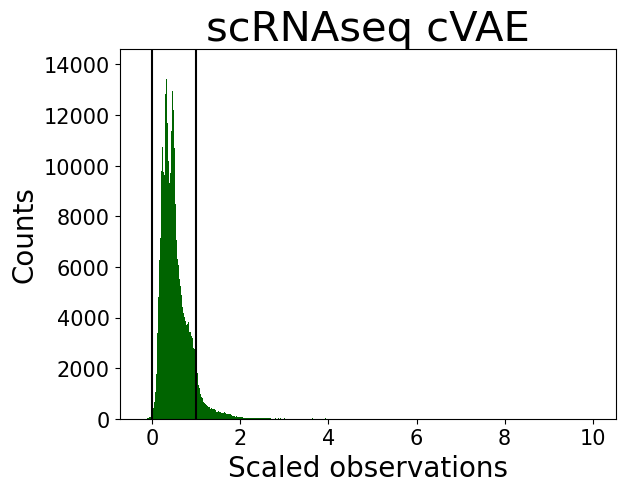

Percentage of predictions that are bigger than 1, settings_polarbear_atac2rna:0.7729249968400576
Percentage of predictions that are smaller than 0, settings_polarbear_atac2rna: 0.15264988146362365


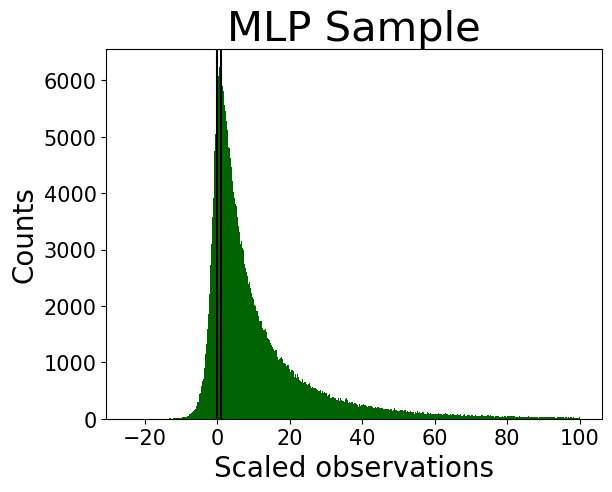

Percentage of predictions that are bigger than 1, settings_sane_atac2rna:0.813421256194043
Percentage of predictions that are smaller than 0, settings_sane_atac2rna: 0.18358262681034548


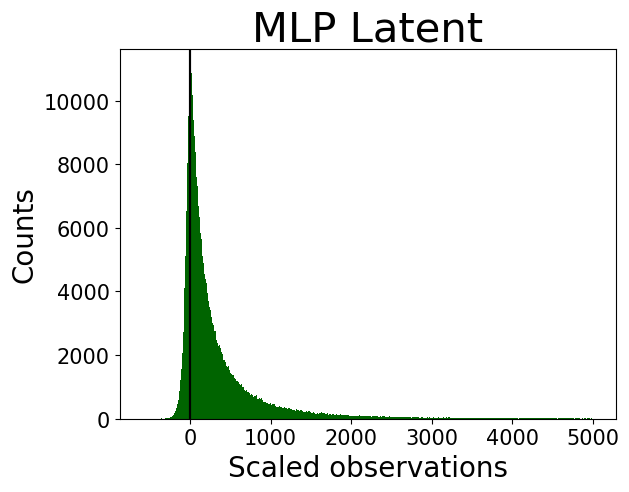

Percentage of predictions that are bigger than 1, doublesample_atac2rna_v1:0.6779876367850749
Percentage of predictions that are smaller than 0, doublesample_atac2rna_v1: 0.07910102945246217


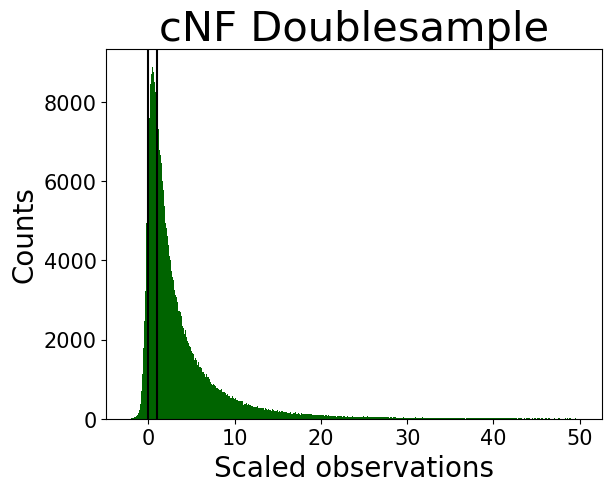

Percentage of predictions that are bigger than 1, latent_atac2rna_v1:0.6857010902228619
Percentage of predictions that are smaller than 0, latent_atac2rna_v1: 0.0824327155556711


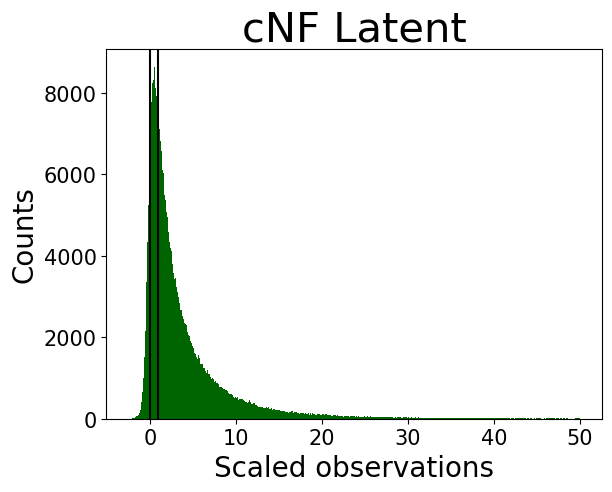

Percentage of predictions that are bigger than 1, sample_atac2rna_v1:0.677876493152863
Percentage of predictions that are smaller than 0, sample_atac2rna_v1: 0.07882501693246431


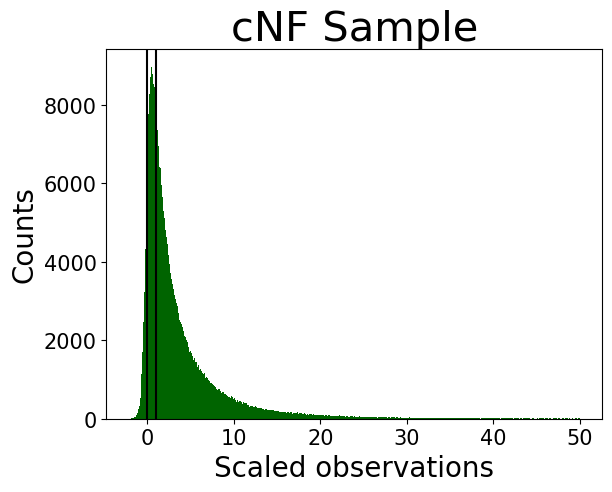

In [14]:
model_names = ["scRNAseq cVAE", "MLP Sample", "MLP Latent", "cNF Doublesample", "cNF Latent", "cNF Sample"]
for i, name in enumerate(plot_df.keys()):
    obs_scale = np.asarray(plot_df[name])
    print(f"Percentage of predictions that are bigger than 1, {name}:{(obs_scale > 1).sum() / obs_scale.shape[0]}")
    print(f"Percentage of predictions that are smaller than 0, {name}: {(obs_scale < 0).sum() / obs_scale.shape[0]}")
    plt.hist(plot_df[name], bins=1000, color="darkgreen")
    plt.xlabel("Scaled observations", fontsize=20)
    plt.title(f"{model_names[i]}", fontsize=30)
    plt.ylabel("Counts", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.axvline(1, color="black")
    plt.axvline(0, color="black")
    plt.savefig(os.path.join(save_fig, f"atac2rna_ci_{name}.pdf"))
    plt.show()

# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
# for i, name in enumerate(plot_df.keys()):
#    row, col = i // 3, i % 3
#    ax = axes[row, col]
#    ax.hist(plot_df[name], bins=1000, color="darkgreen")
#    ax.axvline(1, color="black")
#    ax.axvline(0, color="black")
#    ax.set_title(f"{model_names[i]}")
# fig.supxlabel("scaled observations")
# fig.suptitle("ATAC-to-RNA Tranlsators, Confidence Intervals for Differentially expressed genes")

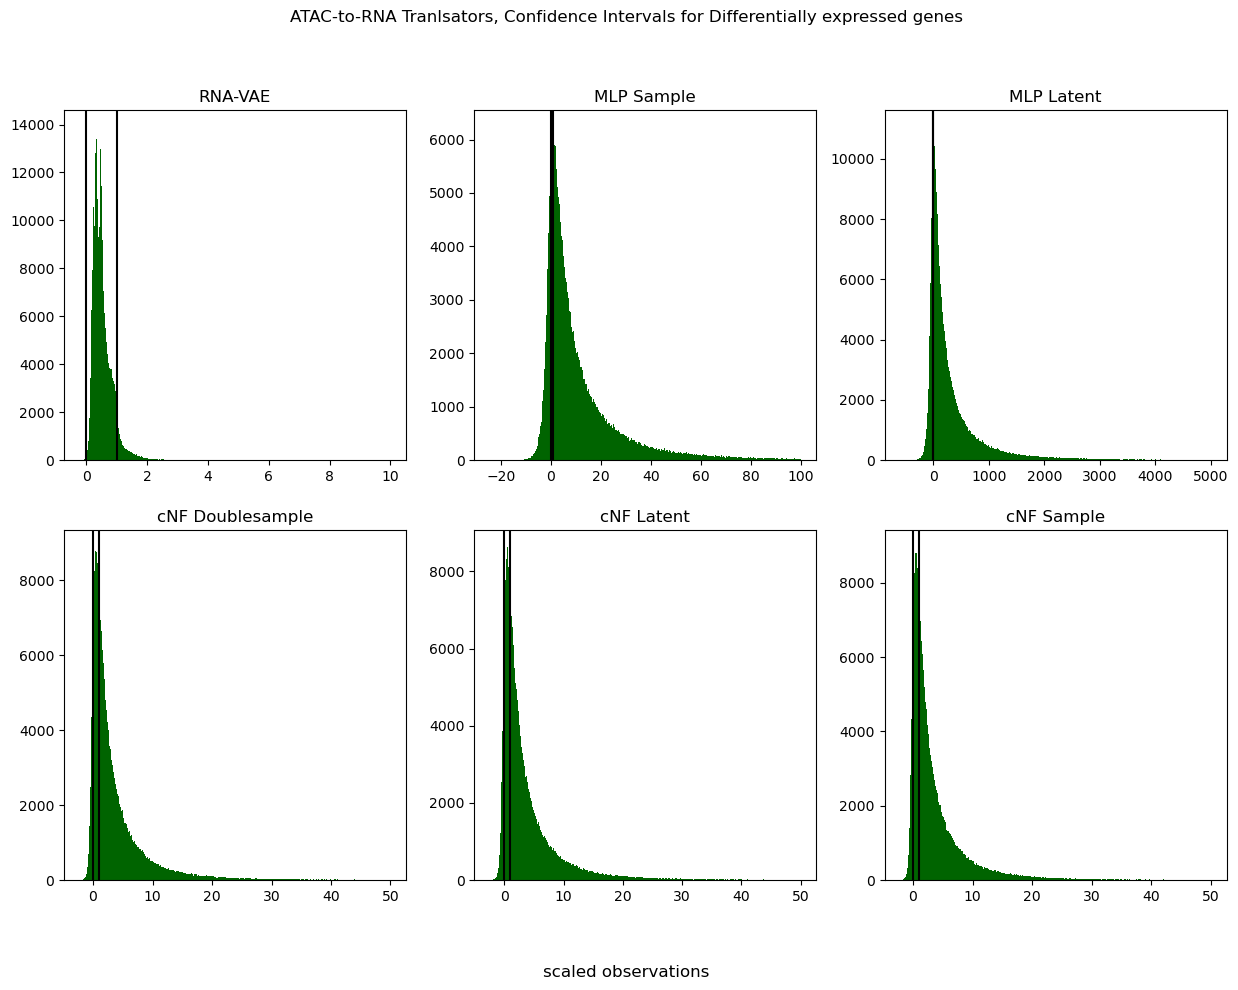

In [15]:
model_names = ["RNA-VAE", "MLP Sample", "MLP Latent", "cNF Doublesample", "cNF Latent", "cNF Sample"]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, name in enumerate(plot_df.keys()):
    row, col = i // 3, i % 3
    ax = axes[row, col]
    ax.hist(plot_df[name], bins=1000, color="darkgreen")
    ax.axvline(1, color="black")
    ax.axvline(0, color="black")
    ax.set_title(f"{model_names[i]}")
fig.supxlabel("scaled observations")
fig.suptitle("ATAC-to-RNA Tranlsators, Confidence Intervals for Differentially expressed genes")
fig.savefig(os.path.join(save_fig, "atac2rna_translators_ci.pdf"))

## RNAVAE

/tmp/ipykernel_39847/3893850416.py:3: RuntimeWarning: divide by zero encountered in divide
  obs_scale = (counts[condition] - q025[condition]) / (q975[condition] - q025[condition])


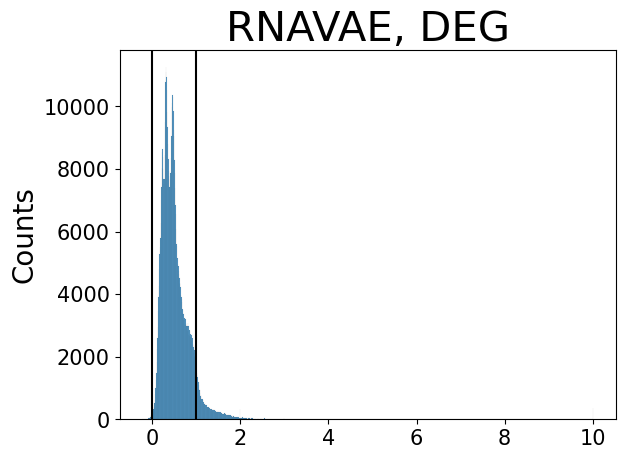

In [16]:
q025, q975 = read_vae(data_dir="/data/mikulik/mnt_polarbear_exp/", vae="rnavae")
obs_scale = scale_quantiles(obs_rna[:, diff_genes_ind], q025[:, diff_genes_ind], q975[:, diff_genes_ind])
plot_ci(np.clip(obs_scale.reshape(-1), -1, 10), title="RNAVAE, DEG")
plot_df["RNAVAE"] = np.clip(obs_scale.reshape(-1), -1, 10).tolist()

In [17]:
ind_arr = get_index_array(obs_rna)
ind_arr = ind_arr[:, diff_genes_ind]
rna_diff = obs_rna[:, diff_genes_ind]
ind_arr = ind_arr[rna_diff > 0]

In [18]:
explore = ind_arr[obs_scale > 10]
print(explore.shape)
# print(len(explore))
explore = index_1d_to_2d(explore, width=obs_norm.shape[1])
explore[0].shape, explore[1].shape

(372,)


((372,), (372,))

In [19]:
explore[0]

array([   0,    1,    3,   10,   15,   23,   24,   26,   29,   35,   38,
         49,   51,   54,   54,   55,   58,   61,   68,   72,   72,   78,
         85,   87,   96,  103,  113,  118,  122,  122,  144,  158,  164,
        167,  172,  179,  195,  197,  205,  208,  212,  217,  219,  221,
        223,  223,  223,  229,  240,  241,  243,  243,  257,  264,  288,
        288,  291,  291,  294,  296,  296,  298,  305,  312,  313,  315,
        316,  317,  325,  327,  327,  327,  328,  343,  356,  357,  368,
        388,  388,  388,  388,  388,  388,  388,  388,  401,  401,  411,
        411,  415,  424,  428,  441,  444,  444,  447,  457,  458,  484,
        489,  489,  495,  498,  499,  505,  508,  513,  513,  518,  520,
        542,  545,  555,  558,  571,  573,  576,  576,  579,  579,  580,
        581,  600,  607,  608,  626,  628,  641,  649,  650,  651,  653,
        662,  689,  689,  700,  702,  706,  715,  720,  733,  733,  733,
        743,  753,  763,  771,  775,  776,  776,  7

In [20]:
test_cell_names.iloc[[54, 54]]

,Batch,Barcode,Ident
09E_ATGCATCCTCCA,09E,ATGCATCCTCCA,Mis
09E_ATGCATCCTCCA,09E,ATGCATCCTCCA,Mis


In [21]:
a = test_cell_names.iloc[explore[0]]
a

,Batch,Barcode,Ident
09I_CCTACATCGGAA,09I,CCTACATCGGAA,OliM
09C_CCATCCGACCCT,09C,CCATCCGACCCT,Mis
09L_GTCAACGATGCA,09L,GTCAACGATGCA,E3Rorb
09K_TCTTGTCACCTC,09K,TCTTGTCACCTC,E4Thsd7a
09B_GCGTTTCCATGT,09B,GCGTTTCCATGT,E5Galnt14
...,...,...,...
09F_GATACGCTACCG,09F,GATACGCTACCG,Mis
09J_TATGTCCACCTT,09J,TATGTCCACCTT,E2Rasgrf2
09E_CTTGTTTACTCG,09E,CTTGTTTACTCG,OliM
09E_CTTGTTTACTCG,09E,CTTGTTTACTCG,OliM


<Axes: xlabel='count', ylabel='Ident'>

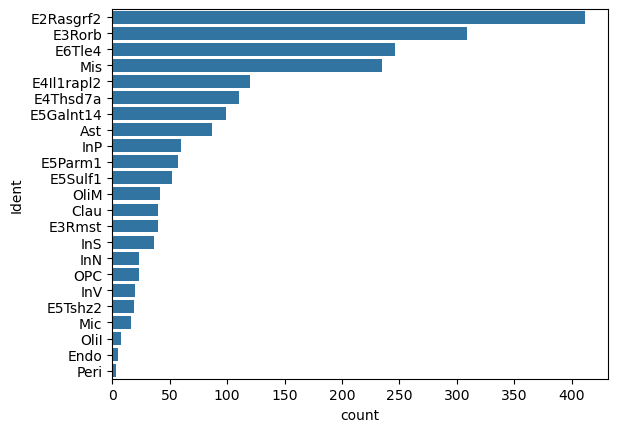

In [22]:
sns.barplot(test_cell_names.value_counts("Ident").reset_index("Ident"), y="Ident", x="count")

<Axes: xlabel='count', ylabel='Ident'>

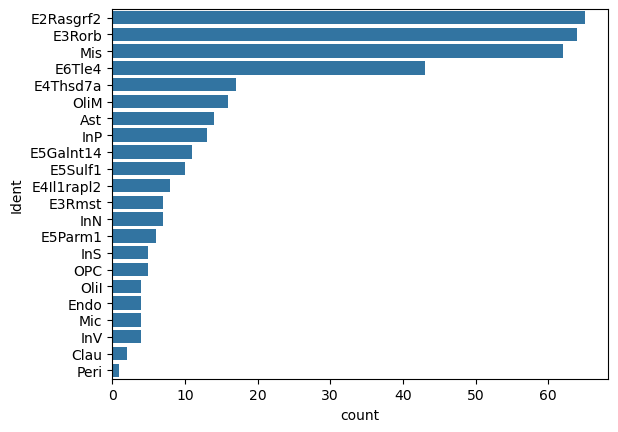

In [248]:
sns.barplot(a.value_counts("Ident").reset_index("Ident"), y="Ident", x="count")

In [23]:
a.value_counts("Ident")

Ident
E2Rasgrf2     65
E3Rorb        64
Mis           62
E6Tle4        43
E4Thsd7a      17
OliM          16
Ast           14
InP           13
E5Galnt14     11
E5Sulf1       10
E4Il1rapl2     8
E3Rmst         7
InN            7
E5Parm1        6
InS            5
OPC            5
OliI           4
Endo           4
Mic            4
InV            4
Clau           2
Peri           1
Name: count, dtype: int64

In [25]:
explore_genes = gene_names[gene_names.ind.isin(explore[1])].ind.tolist()
print(diff_genes[diff_genes.Gene.isin(gene_names[gene_names.ind.isin(explore_genes)].gene)].Gene.nunique())
gene_names[gene_names.ind.isin(explore_genes)]

138


,gene,ind
83,Pip5k1b,83
284,Egfr,284
326,Vip,326
436,Arhgap31,436
437,Gad1,437
...,...,...
16024,Mog,16024
16498,Phkg1,16498
16633,Ccp110,16633
16686,Nxph1,16686


In [26]:
tmp_df = diff_genes[diff_genes.Gene.isin(gene_names[gene_names.ind.isin(explore_genes)].gene)].drop_duplicates(
    subset="Gene", keep="first"
)

In [28]:
tmp_df.Cluster.value_counts()

Cluster
Ast                 24
Oli-Itpr2           16
Mic                 12
Oli-Mal             12
In-Pvalb            12
In-Npy               8
In-Sst               6
Claustrum            6
Ex-L5/6-Tshz2        5
OPC                  5
Peri                 5
Ex-L5-Parm1          5
In-Vip               4
Ex-L4/5-Thsd7a       4
Ex-L2/3-Rasgrf2      3
Ex-L3/4-Rorb         2
Ex-L5/6-Sulf1        2
Ex-L4/5-Il1rapl2     2
Endo                 2
Ex-L3/4-Rmst         1
Ex-L5-Galnt14        1
Ex-L6-Tle4           1
Name: count, dtype: int64

<Axes: xlabel='Fold Change (log)', ylabel='Count'>

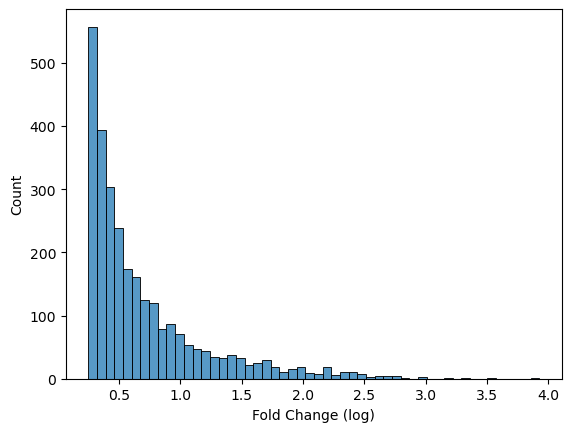

In [29]:
sns.histplot(diff_genes["Fold Change (log)"])

<Axes: xlabel='Fold Change (log)', ylabel='Count'>

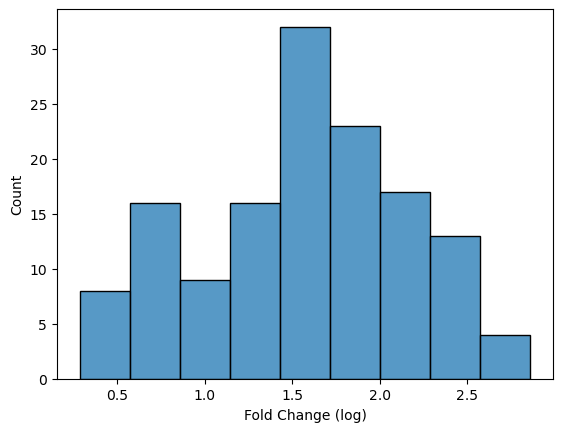

In [30]:
sns.histplot(tmp_df["Fold Change (log)"])

In [31]:
rand_ind = np.random.randint(low=0, high=obs_rna.shape[1], size=200)

<Axes: ylabel='Count'>

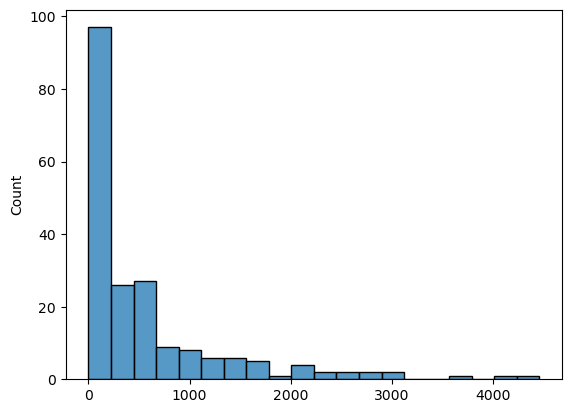

In [32]:
sns.histplot(rna_counts[:, rand_ind].sum(axis=0))

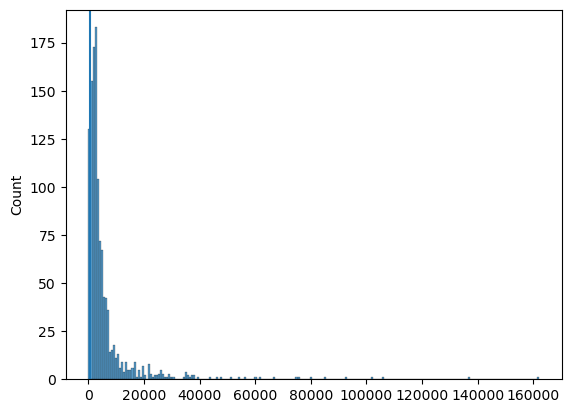

In [33]:
sns.histplot(rna_counts[:, diff_genes_ind].sum(axis=0))
plt.axvline(500)

<Axes: ylabel='Count'>

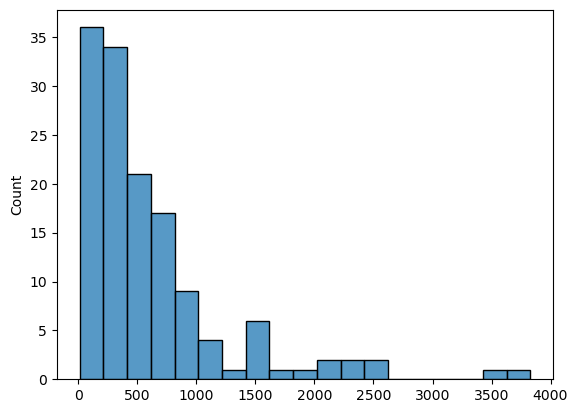

In [34]:
sns.histplot(rna_counts[:, explore_genes].sum(axis=0))

<Axes: >

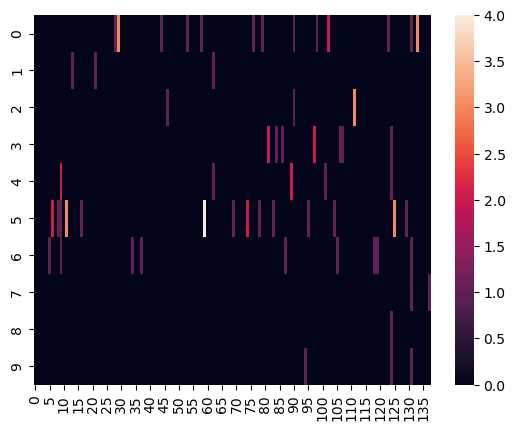

In [36]:
sns.heatmap(obs_rna[:10, explore_genes])

In [37]:
test = gene_names[gene_names.ind.isin(explore_genes)].gene

In [38]:
diff_genes[diff_genes.Gene.isin(test)]

,Gene,Fold Change (log),Percentage (in group),Percentage (out),p-value,Cluster
15,Htr1f,0.940115,0.476,0.181,1.060843e-140,Ex-L6-Tle4
157,Pamr1,0.682293,0.264,0.101,5.681586e-73,Ex-L3/4-Rorb
203,Lin7a,0.464955,0.336,0.241,1.727892e-21,Ex-L3/4-Rorb
237,Calb1,0.763950,0.287,0.062,4.649219e-194,Ex-L2/3-Rasgrf2
248,Lamp5,0.688850,0.323,0.109,3.699791e-137,Ex-L2/3-Rasgrf2
...,...,...,...,...,...,...
2799,Myl3,1.656771,0.316,0.000,0.000000e+00,Peri
2800,Gja4,1.611341,0.316,0.000,0.000000e+00,Peri
2801,Rab15,1.295439,0.368,0.086,2.807999e-06,Peri
2804,Glp2r,0.815523,0.263,0.056,5.546110e-05,Peri
